# Object Detection using Google AI Open Images

In [2]:
# # Below is the code to check wethe GPUs are working on Google Cloud
# # Creates a graph.
# import tensorflow as tf
# c = []
# for d in ['/device:GPU:0', '/device:GPU:1']:
#     with tf.device(d):
#         a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3])
#         b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2])
#         c.append(tf.matmul(a, b))
# with tf.device('/cpu:0'):
#     sum = tf.add_n(c)
# # Creates a session with log_device_placement set to True.
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# # Runs the op.
# print(sess.run(sum))

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[[ 44.  56.]
 [ 98. 128.]]


# Function Definitions

In [1]:
import pandas as pd
import numpy as np
import os
import xml.etree.ElementTree as ET
#import tensorflow as tf
import copy
import cv2
from PIL import ImageFont

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.c     = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def draw_boxes(image, boxes, labels):
    image_h, image_w, _ = image.shape

    for box in boxes:
        xmin = int(box.xmin*image_w)
        ymin = int(box.ymin*image_h)
        xmax = int(box.xmax*image_w)
        ymax = int(box.ymax*image_h)

        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,0,255), 10)
        cv2.putText(image, 
                    labels[box.get_label()] + ' ' + str(box.get_score()), 
                    (xmin, ymin + 20), 
                    cv2.FONT_HERSHEY_TRIPLEX, 
                    1e-3 * image_h, 
                    (255,0,0), 2)
        
    return image          
        
def decode_netout(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
    grid_h, grid_w, nb_box = netout.shape[:3]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]

                    x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    confidence = netout[row,col,b,4]
                    
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    
                    boxes.append(box)

    # suppress non-maximal boxes
    for c in range(nb_class):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            if boxes[index_i].classes[c] == 0: 
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0
                        
    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    
    return boxes    

def compute_overlap(a, b):
    """
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    Parameters
    ----------
    a: (N, 4) ndarray of float
    b: (K, 4) ndarray of float
    Returns
    -------
    overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = np.minimum(np.expand_dims(a[:, 2], axis=1), b[:, 2]) - np.maximum(np.expand_dims(a[:, 0], 1), b[:, 0])
    ih = np.minimum(np.expand_dims(a[:, 3], axis=1), b[:, 3]) - np.maximum(np.expand_dims(a[:, 1], 1), b[:, 1])

    iw = np.maximum(iw, 0)
    ih = np.maximum(ih, 0)

    ua = np.expand_dims((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), axis=1) + area - iw * ih

    ua = np.maximum(ua, np.finfo(float).eps)

    intersection = iw * ih

    return intersection / ua  
    
def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.

    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap      
        
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)

In [2]:
import os
import cv2
import copy
import numpy as np
#import imgaug as ia
#from imgaug import augmenters as iaa
from keras.utils import Sequence
import xml.etree.ElementTree as ET


class BatchGenerator(Sequence):
    def __init__(self, images, 
                       config, 
                       shuffle=True, 
                       jitter=True, 
                       norm=None):
        self.generator = None

        self.images = images
        self.config = config

        self.shuffle = shuffle
        self.jitter  = jitter
        self.norm    = norm

        self.anchors = [BoundBox(0, 0, config['ANCHORS'][2*i], config['ANCHORS'][2*i+1]) for i in range(int(len(config['ANCHORS'])//2))]

        ### augmentors by https://github.com/aleju/imgaug
        # Commenting out this code
        #sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        # Define our sequence of augmentation steps that will be applied to every image
        # All augmenters with per_channel=0.5 will sample one value _per image_
        # in 50% of all cases. In all other cases they will sample new values
        # _per channel_.
        
        # Commenting this code
#         self.aug_pipe = iaa.Sequential(
#             [
#                 # apply the following augmenters to most images
#                 #iaa.Fliplr(0.5), # horizontally flip 50% of all images
#                 #iaa.Flipud(0.2), # vertically flip 20% of all images
#                 #sometimes(iaa.Crop(percent=(0, 0.1))), # crop images by 0-10% of their height/width
#                 sometimes(iaa.Affine(
#                     #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
#                     #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
#                     #rotate=(-5, 5), # rotate by -45 to +45 degrees
#                     #shear=(-5, 5), # shear by -16 to +16 degrees
#                     #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
#                     #cval=(0, 255), # if mode is constant, use a cval between 0 and 255
#                     #mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
#                 )),
#                 # execute 0 to 5 of the following (less important) augmenters per image
#                 # don't execute all of them, as that would often be way too strong
#                 iaa.SomeOf((0, 5),
#                     [
#                         #sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
#                         iaa.OneOf([
#                             iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
#                             iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
#                             iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
#                         ]),
#                         iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
#                         #iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
#                         # search either for all edges or for directed edges
#                         #sometimes(iaa.OneOf([
#                         #    iaa.EdgeDetect(alpha=(0, 0.7)),
#                         #    iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0)),
#                         #])),
#                         iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
#                         iaa.OneOf([
#                             iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
#                             #iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
#                         ]),
#                         #iaa.Invert(0.05, per_channel=True), # invert color channels
#                         iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
#                         iaa.Multiply((0.5, 1.5), per_channel=0.5), # change brightness of images (50-150% of original value)
#                         iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
#                         #iaa.Grayscale(alpha=(0.0, 1.0)),
#                         #sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
#                         #sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))) # sometimes move parts of the image around
#                     ],
#                     random_order=True
#                 )
#             ],
#             random_order=True
#         )

        if shuffle: np.random.shuffle(self.images)

    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))   

    def num_classes(self):
        return len(self.config['LABELS'])

    def size(self):
        return len(self.images)    

    def load_annotation(self, i):
        annots = []

        for obj in self.images[i]['object']:
            annot = [obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'], self.config['LABELS'].index(obj['name'])]
            annots += [annot]

        if len(annots) == 0: annots = [[]]

        return np.array(annots)

    def load_image(self, i):
        return cv2.imread(self.images[i]['filename'])

    def __getitem__(self, idx):
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0

        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))                         # input images
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))                # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.aug_image(train_instance, jitter=self.jitter)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x = .5*(obj['xmin'] + obj['xmax'])
                    center_x = center_x / (float(self.config['IMAGE_W']) / self.config['GRID_W'])
                    center_y = .5*(obj['ymin'] + obj['ymax'])
                    center_y = center_y / (float(self.config['IMAGE_H']) / self.config['GRID_H'])

                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])
                        
                        center_w = (obj['xmax'] - obj['xmin']) / (float(self.config['IMAGE_W']) / self.config['GRID_W']) # unit: grid cell
                        center_h = (obj['ymax'] - obj['ymin']) / (float(self.config['IMAGE_H']) / self.config['GRID_H']) # unit: grid cell
                        
                        box = [center_x, center_y, center_w, center_h]

                        # find the anchor that best predicts this box
                        best_anchor = -1
                        max_iou     = -1
                        
                        shifted_box = BoundBox(0, 
                                               0,
                                               center_w,                                                
                                               center_h)
                        
                        for i in range(len(self.anchors)):
                            anchor = self.anchors[i]
                            iou    = bbox_iou(shifted_box, anchor)
                            
                            if max_iou < iou:
                                best_anchor = i
                                max_iou     = iou
                                
                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1.
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1
                        
                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            # assign input image to x_batch
            if self.norm != None: 
                x_batch[instance_count] = self.norm(img)
            else:
                # plot image and bounding boxes for sanity check
                for obj in all_objs:
                    if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin']:
                        cv2.rectangle(img[:,:,::-1], (obj['xmin'],obj['ymin']), (obj['xmax'],obj['ymax']), (255,0,0), 3)
                        cv2.putText(img[:,:,::-1], obj['name'], 
                                    (obj['xmin']+2, obj['ymin']+12), 
                                    0, 1.2e-3 * img.shape[0], 
                                    (0,255,0), 2)
                        
                x_batch[instance_count] = img

            # increase instance counter in current batch
            instance_count += 1  

        #print(' new batch created', idx)

        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.images)

    def aug_image(self, train_instance, jitter):
        image_name = train_instance['filename']
        image = cv2.imread(image_name)

        if image is None: print('Cannot find ', image_name)

        h, w, c = image.shape
        all_objs = copy.deepcopy(train_instance['object'])

        if jitter:
            ### scale the image
            scale = np.random.uniform() / 10. + 1.
            image = cv2.resize(image, (0,0), fx = scale, fy = scale)

            ### translate the image
            max_offx = (scale-1.) * w
            max_offy = (scale-1.) * h
            offx = int(np.random.uniform() * max_offx)
            offy = int(np.random.uniform() * max_offy)
            
            image = image[offy : (offy + h), offx : (offx + w)]

            ### flip the image
            flip = np.random.binomial(1, .5)
            if flip > 0.5: image = cv2.flip(image, 1)
            # Commenting this code    
            image = image #self.aug_pipe.augment_image(image)            
            
        # resize the image to standard size
        image = cv2.resize(image, (self.config['IMAGE_H'], self.config['IMAGE_W']))
        image = image[:,:,::-1]

        # fix object's position and size
        for obj in all_objs:
            for attr in ['xmin', 'xmax']:
                if jitter: obj[attr] = int(obj[attr] * scale - offx)
                    
                obj[attr] = int(obj[attr] * float(self.config['IMAGE_W']) / w)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_W']), 0)
                
            for attr in ['ymin', 'ymax']:
                if jitter: obj[attr] = int(obj[attr] * scale - offy)
                    
                obj[attr] = int(obj[attr] * float(self.config['IMAGE_H']) / h)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_H']), 0)

            if jitter and flip > 0.5:
                xmin = obj['xmin']
                obj['xmin'] = self.config['IMAGE_W'] - obj['xmax']
                obj['xmax'] = self.config['IMAGE_W'] - xmin
                
        return image, all_objs

C:\Users\bandi\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Key Inputs to the YOLO Algorithm

In [3]:
LABELS = ['Shirt', 'Trousers', 'Swimwear', 'Tie', 'Bus', 'Truck', 'Train', 'Motorcycle', 'Helmet', 'Shorts', 'Airplane', 
         'Sunglasses', 'Jacket', 'Dress', 'Human eye', 'Suit', 'Footwear', 'Woman', 'Human face', 'Man', 'Human arm', 
          'Human head','Human hand', 'Human leg', 'Human nose', 'Human mouth', 'Human ear', 'Human beard', 'Human foot', 'Car',
          'Wheel', 'Boat', 'House', 'Bird', 'Guitar', 'Fast food', 'Hat', 'Dog', 'Laptop', 'Beer', 'Cat', 'Lantern', 'Fountain']

IMAGE_H, IMAGE_W = 608, 608
GRID_H,  GRID_W  = 19 , 19
BOX              = 5
# Getting the total number of classes/labels we will be predicting.
CLASS            = len(LABELS)

# Assigning 1's to all class labels
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')

# Pr (object in class) * Pr (class of the object) < Obj_threshold, then it disregards this anchor box
OBJ_THRESHOLD    = 0.3#0.5

# If there are many overlapping boxes and IOU is > NMS_thereshold, then we will drop the one with a lower probability. 
NMS_THRESHOLD    = 0.3#0.45

# Anchors changed
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 16
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

In [9]:
# Loading pre-trained Yolo Weights
wt_path = '../../Weights/yolo.weights'

In [10]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
#Here x is the input. This function basically converts height and widths to depths.
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [11]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
#import imgaug as ia
#from imgaug import augmenters as iaa
import numpy as np
#import pickle
import os, cv2

# The below 2 imports are done from preprocessing.py and utils.py in the utils folder of Anaconda (C:\Users\bandi\Anaconda3\Lib\site-packages\utils)
# These files were manually added so that these functions could be imported.

#from utils.preprocessing import parse_annotation, BatchGenerator
#from utils.utils import WeightReader, decode_netout, draw_boxes

#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

# YOLO Architecture

In [12]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 608, 608, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 608, 608, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_23 (LeakyReLU)      (None, 608, 608, 32) 0           norm_1[0][0]                     
__________________________________________________________________________________________________
max_poolin

# Load YOLO Pre-trained Weights

In [13]:
#from utils.utils import WeightReader
weight_reader = WeightReader(wt_path)

In [14]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)
        
        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        
        conv_layer.set_weights([kernel, bias])
        
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

# Transfer Learning - Re-initialize the Weights of the Last Convolutional Layer of YOLO

In [15]:
layer   = model.layers[-4] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

# Loss Function

In [16]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

# Pass the annotations to construct train generator and validation generator

In [29]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [30]:
# Importing yolo input format for all 200K images
df_yolo_input = pd.read_csv('apm-project/Data/df_yolo_input.csv',header = None)

# set column names
df_yolo_input.columns = ['filename', 'height', 'object', 'width']
# Convert string to list
import ast
def convert_string_to_list (s):
    return ast.literal_eval(s)

df_yolo_input['object'] = df_yolo_input['object'].map(convert_string_to_list)

yolo_input_format = df_yolo_input.to_dict('records')

In [31]:
# We will use 80% of the images for training data set and remaining 30% as validation set.
from sklearn.model_selection import train_test_split
yolo_input_format_train, yolo_input_format_val = train_test_split(yolo_input_format, test_size = 0.4, random_state = 2)

In [32]:
def normalize(image):
    return image / 255.

train_imgs = yolo_input_format_train

train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

valid_imgs = yolo_input_format_val
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

# Setup a few callbacks and start the training¶

In [33]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            min_delta=0.001,
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

checkpoint = ModelCheckpoint('weights_google_open_images.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)



# Train the Network -- This was Done Using NVIDIA Tesla K80 GPU on Google Cloud Platform 

In [36]:
# tb_counter  = len([log for log in os.listdir(os.path.expanduser('~/logs/')) if 'google_open_images_' in log]) + 1
# tensorboard = TensorBoard(log_dir=os.path.expanduser('~/logs/') + 'google_open_images_' + '_' + str(tb_counter), 
#                            histogram_freq=0, 
#                            write_graph=True, 
#                            write_images=False)

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = int(len(train_batch)/16), 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = int(len(valid_batch)/16),
                    callbacks        = [early_stop, checkpoint,learning_rate_reduction],#, tensorboard], 
                    max_queue_size   = 3)

Epoch 1/100
671/671 [==============================] - 1648s 2s/step - loss: 2.8128 - val_loss: 2.0535

Epoch 00001: val_loss improved from inf to 2.05353, saving model to weights_google_open_images.h5
Epoch 2/100
671/671 [==============================] - 1405s 2s/step - loss: 2.0503 - val_loss: 1.8317

Epoch 00002: val_loss improved from 2.05353 to 1.83169, saving model to weights_google_open_images.h5
Epoch 3/100
671/671 [==============================] - 1404s 2s/step - loss: 1.8781 - val_loss: 1.7893

Epoch 00003: val_loss improved from 1.83169 to 1.78930, saving model to weights_google_open_images.h5
Epoch 4/100
671/671 [==============================] - 1404s 2s/step - loss: 1.8207 - val_loss: 1.6769

Epoch 00004: val_loss improved from 1.78930 to 1.67685, saving model to weights_google_open_images.h5
Epoch 5/100
671/671 [==============================] - 1405s 2s/step - loss: 1.7337 - val_loss: 1.6377

Epoch 00005: val_loss improved from 1.67685 to 1.63769, saving model to weig

KeyboardInterrupt: 

# Perform Testing 

## Load the weights trained on the new data set

In [17]:
model.load_weights("google_open_images.h5")
#model.load_weights("../classes_30/weights_google_open_images_30_classes.h5")

In [28]:
def draw_boxes(image, boxes, labels):
    image_h, image_w, _ = image.shape

    for box in boxes:
        xmin = int(box.xmin*image_w)
        ymin = int(box.ymin*image_h)
        xmax = int(box.xmax*image_w)
        ymax = int(box.ymax*image_h)

        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,0,255), 8)
        cv2.putText(image, 
                    labels[box.get_label()] + ' ' + str(round(box.get_score(),2)), 
                    (xmin  , ymin ), 
                    cv2.FONT_HERSHEY_TRIPLEX, 
                    1e-3 * image_h*1, 
                    (255,255,255), 7)
        
    return image          

## Perform Testing on a Test Image

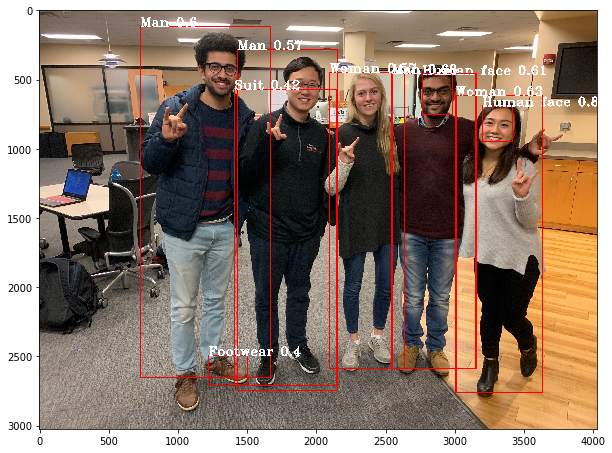

In [29]:
image = cv2.imread('../../../../validation/group_pic.jpg')

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (608, 608))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=0.4,
                      nms_threshold=0.3,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)


plt.imshow(image[:,:,::-1]); plt.show()

## Perform Testing on a Video

In [463]:
from tqdm import tqdm
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

video_inp = '../../../../validation/car_traffic.mp4'
video_out = '../../../../validation/car_traffic_predicted.mp4'

video_reader = cv2.VideoCapture(video_inp)

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'XVID'), 
                               50.0, 
                               (frame_w, frame_h))


for i in tqdm(range(nb_frames)):
    ret, image = video_reader.read()
    
    
    input_image = cv2.resize(image, (608, 608))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=0.3,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    image = draw_boxes(image, boxes, labels=LABELS)
    

    video_writer.write(np.uint8(image))
    
video_reader.release()
video_writer.release()



  0%|          | 0/2356 [00:00<?, ?it/s]

  0%|          | 1/2356 [00:01<44:39,  1.14s/it]

  0%|          | 2/2356 [00:02<45:25,  1.16s/it]

  0%|          | 3/2356 [00:03<44:27,  1.13s/it]

  0%|          | 4/2356 [00:04<43:34,  1.11s/it]

  0%|          | 5/2356 [00:05<43:19,  1.11s/it]

  0%|          | 6/2356 [00:06<43:13,  1.10s/it]

  0%|          | 7/2356 [00:07<44:19,  1.13s/it]

  0%|          | 8/2356 [00:09<47:56,  1.22s/it]

  0%|          | 9/2356 [00:10<49:47,  1.27s/it]

  0%|          | 10/2356 [00:12<51:38,  1.32s/it]

  0%|          | 11/2356 [00:13<53:46,  1.38s/it]

  1%|          | 12/2356 [00:15<57:00,  1.46s/it]

  1%|          | 13/2356 [00:16<56:00,  1.43s/it]

  1%|          | 14/2356 [00:18<56:21,  1.44s/it]

  1%|          | 15/2356 [00:19<55:40,  1.43s/it]

  1%|          | 16/2356 [00:20<54:20,  1.39s/it]

  1%|          | 17/2356 [00:22<54:15,  1.39s/it]

  1%|          | 18/2356 [00:23<52:47,  1.35s/it]

  1%|          | 19/2356 [00:24<52:04,  1.34s/i

 13%|█▎        | 316/2356 [06:57<43:08,  1.27s/it]

 13%|█▎        | 317/2356 [06:58<42:58,  1.26s/it]

 13%|█▎        | 318/2356 [06:59<42:56,  1.26s/it]

 14%|█▎        | 319/2356 [07:00<42:47,  1.26s/it]

 14%|█▎        | 320/2356 [07:02<42:40,  1.26s/it]

 14%|█▎        | 321/2356 [07:03<42:37,  1.26s/it]

 14%|█▎        | 322/2356 [07:04<42:33,  1.26s/it]

 14%|█▎        | 323/2356 [07:05<42:23,  1.25s/it]

 14%|█▍        | 324/2356 [07:07<42:27,  1.25s/it]

 14%|█▍        | 325/2356 [07:08<42:16,  1.25s/it]

 14%|█▍        | 326/2356 [07:09<43:36,  1.29s/it]

 14%|█▍        | 327/2356 [07:11<43:58,  1.30s/it]

 14%|█▍        | 328/2356 [07:12<43:35,  1.29s/it]

 14%|█▍        | 329/2356 [07:13<43:15,  1.28s/it]

 14%|█▍        | 330/2356 [07:14<43:02,  1.27s/it]

 14%|█▍        | 331/2356 [07:16<42:55,  1.27s/it]

 14%|█▍        | 332/2356 [07:17<43:20,  1.28s/it]

 14%|█▍        | 333/2356 [07:18<44:13,  1.31s/it]

 14%|█▍        | 334/2356 [07:20<44:19,  1.32s/it]

 14%|█▍     

 27%|██▋       | 630/2356 [13:47<35:53,  1.25s/it]

 27%|██▋       | 631/2356 [13:48<36:01,  1.25s/it]

 27%|██▋       | 632/2356 [13:50<36:54,  1.28s/it]

 27%|██▋       | 633/2356 [13:51<36:43,  1.28s/it]

 27%|██▋       | 634/2356 [13:52<36:11,  1.26s/it]

 27%|██▋       | 635/2356 [13:54<36:08,  1.26s/it]

 27%|██▋       | 636/2356 [13:55<35:55,  1.25s/it]

 27%|██▋       | 637/2356 [13:56<35:44,  1.25s/it]

 27%|██▋       | 638/2356 [13:57<35:35,  1.24s/it]

 27%|██▋       | 639/2356 [13:59<35:34,  1.24s/it]

 27%|██▋       | 640/2356 [14:00<35:37,  1.25s/it]

 27%|██▋       | 641/2356 [14:01<35:30,  1.24s/it]

 27%|██▋       | 642/2356 [14:02<35:34,  1.25s/it]

 27%|██▋       | 643/2356 [14:04<35:27,  1.24s/it]

 27%|██▋       | 644/2356 [14:05<36:01,  1.26s/it]

 27%|██▋       | 645/2356 [14:06<36:37,  1.28s/it]

 27%|██▋       | 646/2356 [14:07<36:08,  1.27s/it]

 27%|██▋       | 647/2356 [14:09<36:01,  1.26s/it]

 28%|██▊       | 648/2356 [14:10<35:48,  1.26s/it]

 28%|██▊    

 40%|████      | 944/2356 [20:29<31:03,  1.32s/it]

 40%|████      | 945/2356 [20:30<31:37,  1.34s/it]

 40%|████      | 946/2356 [20:31<31:37,  1.35s/it]

 40%|████      | 947/2356 [20:33<31:16,  1.33s/it]

 40%|████      | 948/2356 [20:34<31:03,  1.32s/it]

 40%|████      | 949/2356 [20:35<31:04,  1.33s/it]

 40%|████      | 950/2356 [20:37<30:49,  1.32s/it]

 40%|████      | 951/2356 [20:38<30:45,  1.31s/it]

 40%|████      | 952/2356 [20:39<30:45,  1.31s/it]

 40%|████      | 953/2356 [20:40<30:10,  1.29s/it]

 40%|████      | 954/2356 [20:42<29:51,  1.28s/it]

 41%|████      | 955/2356 [20:43<29:38,  1.27s/it]

 41%|████      | 956/2356 [20:44<29:34,  1.27s/it]

 41%|████      | 957/2356 [20:46<30:04,  1.29s/it]

 41%|████      | 958/2356 [20:47<30:07,  1.29s/it]

 41%|████      | 959/2356 [20:48<29:36,  1.27s/it]

 41%|████      | 960/2356 [20:49<29:27,  1.27s/it]

 41%|████      | 961/2356 [20:51<29:12,  1.26s/it]

 41%|████      | 962/2356 [20:52<29:20,  1.26s/it]

 41%|████   

 53%|█████▎    | 1253/2356 [27:01<22:59,  1.25s/it]

 53%|█████▎    | 1254/2356 [27:02<22:54,  1.25s/it]

 53%|█████▎    | 1255/2356 [27:03<22:54,  1.25s/it]

 53%|█████▎    | 1256/2356 [27:05<22:47,  1.24s/it]

 53%|█████▎    | 1257/2356 [27:06<22:50,  1.25s/it]

 53%|█████▎    | 1258/2356 [27:07<22:38,  1.24s/it]

 53%|█████▎    | 1259/2356 [27:08<22:46,  1.25s/it]

 53%|█████▎    | 1260/2356 [27:10<23:27,  1.28s/it]

 54%|█████▎    | 1261/2356 [27:11<23:28,  1.29s/it]

 54%|█████▎    | 1262/2356 [27:12<23:14,  1.27s/it]

 54%|█████▎    | 1263/2356 [27:13<23:06,  1.27s/it]

 54%|█████▎    | 1264/2356 [27:15<23:15,  1.28s/it]

 54%|█████▎    | 1265/2356 [27:16<23:01,  1.27s/it]

 54%|█████▎    | 1266/2356 [27:17<22:53,  1.26s/it]

 54%|█████▍    | 1267/2356 [27:19<22:47,  1.26s/it]

 54%|█████▍    | 1268/2356 [27:20<22:40,  1.25s/it]

 54%|█████▍    | 1269/2356 [27:21<22:38,  1.25s/it]

 54%|█████▍    | 1270/2356 [27:22<22:28,  1.24s/it]

 54%|█████▍    | 1271/2356 [27:23<22:29,  1.24

 66%|██████▋   | 1561/2356 [33:30<18:15,  1.38s/it]

 66%|██████▋   | 1562/2356 [33:31<18:28,  1.40s/it]

 66%|██████▋   | 1563/2356 [33:33<18:17,  1.38s/it]

 66%|██████▋   | 1564/2356 [33:34<19:17,  1.46s/it]

 66%|██████▋   | 1565/2356 [33:36<20:51,  1.58s/it]

 66%|██████▋   | 1566/2356 [33:38<21:50,  1.66s/it]

 67%|██████▋   | 1567/2356 [33:39<21:21,  1.62s/it]

 67%|██████▋   | 1568/2356 [33:41<20:45,  1.58s/it]

 67%|██████▋   | 1569/2356 [33:42<19:21,  1.48s/it]

 67%|██████▋   | 1570/2356 [33:43<18:25,  1.41s/it]

 67%|██████▋   | 1571/2356 [33:45<17:51,  1.36s/it]

 67%|██████▋   | 1572/2356 [33:46<17:25,  1.33s/it]

 67%|██████▋   | 1573/2356 [33:47<16:59,  1.30s/it]

 67%|██████▋   | 1574/2356 [33:48<16:47,  1.29s/it]

 67%|██████▋   | 1575/2356 [33:50<17:19,  1.33s/it]

 67%|██████▋   | 1576/2356 [33:51<17:12,  1.32s/it]

 67%|██████▋   | 1577/2356 [33:52<16:51,  1.30s/it]

 67%|██████▋   | 1578/2356 [33:54<16:38,  1.28s/it]

 67%|██████▋   | 1579/2356 [33:55<16:35,  1.28

 79%|███████▉  | 1869/2356 [40:09<10:15,  1.26s/it]

 79%|███████▉  | 1870/2356 [40:10<10:12,  1.26s/it]

 79%|███████▉  | 1871/2356 [40:12<10:12,  1.26s/it]

 79%|███████▉  | 1872/2356 [40:13<10:23,  1.29s/it]

 79%|███████▉  | 1873/2356 [40:14<10:33,  1.31s/it]

 80%|███████▉  | 1874/2356 [40:16<10:28,  1.30s/it]

 80%|███████▉  | 1875/2356 [40:17<10:17,  1.28s/it]

 80%|███████▉  | 1876/2356 [40:18<10:08,  1.27s/it]

 80%|███████▉  | 1877/2356 [40:19<10:06,  1.27s/it]

 80%|███████▉  | 1878/2356 [40:21<10:04,  1.26s/it]

 80%|███████▉  | 1879/2356 [40:22<09:58,  1.26s/it]

 80%|███████▉  | 1880/2356 [40:23<09:57,  1.26s/it]

 80%|███████▉  | 1881/2356 [40:24<09:56,  1.26s/it]

 80%|███████▉  | 1882/2356 [40:26<09:58,  1.26s/it]

 80%|███████▉  | 1883/2356 [40:27<09:54,  1.26s/it]

 80%|███████▉  | 1884/2356 [40:28<09:51,  1.25s/it]

 80%|████████  | 1885/2356 [40:30<10:17,  1.31s/it]

 80%|████████  | 1886/2356 [40:31<10:18,  1.32s/it]

 80%|████████  | 1887/2356 [40:32<10:03,  1.29

 92%|█████████▏| 2177/2356 [46:42<03:47,  1.27s/it]

 92%|█████████▏| 2178/2356 [46:43<03:45,  1.27s/it]

 92%|█████████▏| 2179/2356 [46:45<03:42,  1.26s/it]

 93%|█████████▎| 2180/2356 [46:46<03:41,  1.26s/it]

 93%|█████████▎| 2181/2356 [46:47<03:40,  1.26s/it]

 93%|█████████▎| 2182/2356 [46:48<03:38,  1.26s/it]

 93%|█████████▎| 2183/2356 [46:50<03:37,  1.26s/it]

 93%|█████████▎| 2184/2356 [46:51<03:35,  1.26s/it]

 93%|█████████▎| 2185/2356 [46:52<03:35,  1.26s/it]

 93%|█████████▎| 2186/2356 [46:54<03:41,  1.31s/it]

 93%|█████████▎| 2187/2356 [46:55<03:43,  1.32s/it]

 93%|█████████▎| 2188/2356 [46:56<03:37,  1.29s/it]

 93%|█████████▎| 2189/2356 [46:57<03:33,  1.28s/it]

 93%|█████████▎| 2190/2356 [46:59<03:29,  1.26s/it]

 93%|█████████▎| 2191/2356 [47:00<03:29,  1.27s/it]

 93%|█████████▎| 2192/2356 [47:01<03:28,  1.27s/it]

 93%|█████████▎| 2193/2356 [47:02<03:25,  1.26s/it]

 93%|█████████▎| 2194/2356 [47:04<03:25,  1.27s/it]

 93%|█████████▎| 2195/2356 [47:05<03:23,  1.27